In [6]:
import keras
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

In [7]:
### The below are the codes to mount the files to the Google Colab for GPU acceleration. 

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/My Drive/memory_2nd/')
#os.getcwd()

#!ls

#### Which features did you select? Why?


In [9]:
#reading the pre-processed csv files into pandas dataframe 
pro_train = pd.read_csv('processed_train.csv')
pro_test = pd.read_csv('processed_test.csv')

pro_train_y = pro_train['project_id']
pro_test_y = pro_test['project_id']

pro_train.drop(['updated_at', 'created_at', 'project_id'], axis=1, inplace=True)
pro_test.drop(['updated_at', 'created_at', 'project_id'], axis=1, inplace=True)

In [10]:
#imputing the missing values in the window column

pro_train['window'] = pro_train['window'].fillna('missingvaluesoverhere')
pro_train['window'] = pro_train['window'].fillna('missingvaluesoverhere')


In [11]:
#turning all the data columns in to the text columns

columns = ['missing_apps', 'window_missing', 'update_duration', 'created_at_day', 'created_at_week',	
           'created_at_hour',	'updated_at_mins', 'created_at_mins', 'created_at_secs', 'updated_at_secs']

for col in columns:
    pro_train[col] = pro_train[col].astype(str) + col
    pro_test[col] = pro_test[col].astype(str) + col

In [12]:
pro_train

,name,window,missing_apps,window_missing,update_duration,created_at_day,created_at_week,created_at_hour,updated_at_mins,created_at_mins,created_at_secs,updated_at_secs
0,iTerm2,2. bash,1missing_apps,0window_missing,0.0update_duration,21created_at_day,12created_at_week,8created_at_hour,12updated_at_mins,12created_at_mins,7created_at_secs,7updated_at_secs
1,Slack,missingvaluesoverhere,1missing_apps,1window_missing,78.0update_duration,15created_at_day,11created_at_week,8created_at_hour,1updated_at_mins,0created_at_mins,4created_at_secs,22updated_at_secs
2,Memory,Slack - Memory,0missing_apps,0window_missing,0.0update_duration,27created_at_day,13created_at_week,7created_at_hour,31updated_at_mins,31created_at_mins,37created_at_secs,37updated_at_secs
3,PyCharm,ai-experiments [~/PycharmProjects/ai-experimen...,1missing_apps,0window_missing,0.0update_duration,21created_at_day,12created_at_week,8created_at_hour,10updated_at_mins,10created_at_mins,58created_at_secs,58updated_at_secs
4,Skype,Item-0,1missing_apps,0window_missing,30.0update_duration,15created_at_day,11created_at_week,8created_at_hour,1updated_at_mins,0created_at_mins,32created_at_secs,2updated_at_secs
5,zoom.us,Item-0,1missing_apps,0window_missing,100.0update_duration,13created_at_day,11created_at_week,8created_at_hour,11updated_at_mins,9created_at_mins,43created_at_secs,23updated_at_secs
6,Memory,Slack - Memory,0missing_apps,0window_missing,92.0update_duration,13created_at_day,11created_at_week,8created_at_hour,10updated_at_mins,9created_at_mins,21created_at_secs,53updated_at_secs
7,Memory,Slack - Memory,0missing_apps,0window_missing,0.0update_duration,21created_at_day,12created_at_week,8created_at_hour,12updated_at_mins,12created_at_mins,47created_at_secs,47updated_at_secs
8,PyCharm,Git,1missing_apps,0window_missing,0.0update_duration,27created_at_day,13created_at_week,7created_at_hour,31updated_at_mins,31created_at_mins,37created_at_secs,37updated_at_secs
9,Preview,milestones_37.png,1missing_apps,0window_missing,9.0update_duration,19created_at_day,12created_at_week,8created_at_hour,28updated_at_mins,28created_at_mins,37created_at_secs,46updated_at_secs


In [13]:
# joining all the text columns as a single text column 
pro_train = pro_train.apply(lambda x: ' '.join(x.astype(str)), axis=1)
pro_test = pro_test.apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [14]:
pro_train

0       iTerm2 2. bash 1missing_apps 0window_missing 0...
1       Slack missingvaluesoverhere 1missing_apps 1win...
2       Memory Slack - Memory 0missing_apps 0window_mi...
3       PyCharm ai-experiments [~/PycharmProjects/ai-e...
4       Skype Item-0 1missing_apps 0window_missing 30....
5       zoom.us Item-0 1missing_apps 0window_missing 1...
6       Memory Slack - Memory 0missing_apps 0window_mi...
7       Memory Slack - Memory 0missing_apps 0window_mi...
8       PyCharm Git 1missing_apps 0window_missing 0.0u...
9       Preview milestones_37.png 1missing_apps 0windo...
10      PyCharm ai-experiments [~/PycharmProjects/ai-e...
11      psutil.readthedocs.io psutil documentation — p...
12      zoom.us Item-0 1missing_apps 0window_missing 0...
13      TextEdit Untitled 1missing_apps 0window_missin...
14      google.no amend commit to master protected - G...
15      machinelearningmastery.com Dropout Regularizat...
16      MySQLWorkbench MySQL Workbench 1missing_apps 0...
17      PyChar

In [15]:
#Here I've used Keras tokenizer object to tokenize the text

In [16]:
tokenizer_obj = Tokenizer()

tokenizer_obj.fit_on_texts(pro_train)

As an additional pre-processing step, we want to make sure that our text column is in good shape for standard processing. That is, our network will expect a standard fixed input text size, and so, we'll want to shape our text into a specific length. 

We can pad the text with zeroes at the end so that we have text rows with the same length.

In [17]:
# pad sequences
max_length = max([len(s.split()) for s in pro_train]) #this should be the max length of all the input rows
max_length

34

In [18]:
# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1 #unique tokens
vocab_size

1800

In [19]:
X_train_tokens =  tokenizer_obj.texts_to_sequences(pro_train)
X_test_tokens =  tokenizer_obj.texts_to_sequences(pro_test)


In [20]:
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')
X_train_pad

array([[ 66,  86, 172, ...,   0,   0,   0],
       [130,  26,  17, ...,   0,   0,   0],
       [ 83, 130,  83, ...,   0,   0,   0],
       ...,
       [ 66,  48, 172, ...,   1,   3,   0],
       [105,  18,  24, ...,  33,   1,   3],
       [104, 119,  26, ...,   0,   0,   0]], dtype=int32)

##### Reference https://github.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/blob/master/lstm-gru-sentiment-analysis.ipynb

### What are the results on the test dataset?

### Which model(s) did you select? Why?

### Description of LSTM

LSTMs are the type of the recurrent neural nets. In recurrent neural nets weight parameters are shared between the hidden units. That means information given to the hidden unit at time t is not only coming from input unit but also from the hidden units of previous time stamps. So the input nodes and previous hidden states are concatenated together and then multiplied with weights. As a result, back-propagation through time is carried out as the inputs from the previous timestamps are also considered. The sequential learning by sharing the weights is carried within the sequence length hyperparameter in the RNN layer.

In reality the LSTM network is implemented as given below at the left side of the diagram i.e. folded/rolled network. Right-side of the diagram showing unfolded network is just for the people to understand all the math and computational theory (it's like we are "imagining" how the network will be when it is unrolled).

<img src="unrolled.png" width="401" height="153">


In tensorflow implementation, Recurrent Neural Networks have loops (`tf.while_loop` is used in the source code) as shown at the left-side of the above diagram allowing information (sequential input) to process input data sequentially **over the time-steps**.

Due to the backpropagation through time, RNN faces vanishing/exploding gradient descent problem. Gradient clipping is applied to deal with exploding gradient descent. Long Short Term Memory (LSTMs) comes in to deal with the problem of vanishing gradient descent problem.

LSTM cell have 4 memory gates. These memory gates help the LSTM to keep its memory longer when it needs and forgets about the events when it should. Each gate has their own set of shared parameter i.e. own neural nets.

In LSTMs, there are 3 inputs (current event, short term events and long term events). 
LSTM  has learn gate, forget gate, remember gate and the use gate, and uses tanh and sigmoid functions in the network. The below is the diagram depicting the LSTM architect;

<img src="lstm.png" width="401" height="153">


Reference http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Building LSTM Model. 
#Reference https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb

1.
An embedding layer that converts our word tokens (integers) into embeddings of a specific size.
We need to add an embedding layer because there are 1800 words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. 

2.
An LSTM layer defined by a hidden_state size, a dropout probability (for dropout between multiple layers)
Most of the time, your network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships.

3.
A fully-connected output layer that maps the LSTM layer outputs to a desired output_size

4.
A softmax output layer which turns all outputs into a value 0-1

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers.embeddings import Embedding

In [22]:
#Applied one hot encoding to the class labels.

le = OneHotEncoder()
train_y_enc = le.fit_transform(np.array(pro_train_y).reshape(-1,1)).toarray()
test_y_enc = le.transform(np.array(pro_test_y).reshape(-1,1)).toarray()

/home/rahul/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
##reference 
### https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
# To compute the class weights in order to deal with class imbalance problem 

cl_weights = class_weight.compute_class_weight('balanced', np.unique(pro_train_y), pro_train_y)

#### I've created the checkpoints if there's model improvement, the weight get to be saved on to the disk then and the model retains the best weight after the end of epochs. 

In [24]:
#reference https://keras.io/

EMBEDDING_DIM = 100

print('Build model...')

model = Sequential()

# embedding weights are initialized random uniformly
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))

# Weights initialized with Xavier (glorot_uniform)
model.add(LSTM(units=100, recurrent_dropout=0.3))

#Softmax classifier layer for 5 number of classes
model.add(Dense(5, activation='softmax'))

#optimizer function, loss function defined
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 100)           180000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 260,905
Trainable params: 260,905
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
print('Train...')
#y_train = pd.get_dummies(df['project_id'])
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
call_list = [checkpoint]

history = model.fit(X_train_pad, train_y_enc, batch_size=128, epochs=35, validation_data=(X_test_pad, test_y_enc), 
          verbose=2, class_weight=cl_weights, callbacks= call_list)

Train...
Train on 2768 samples, validate on 30885 samples
Epoch 1/35
 - 11s - loss: 1.0691 - acc: 0.8291 - val_loss: 0.6083 - val_acc: 0.8454

Epoch 00001: val_acc improved from -inf to 0.84539, saving model to weights-improvement-01-0.85.hdf5
Epoch 2/35
 - 10s - loss: 0.6043 - acc: 0.8472 - val_loss: 0.5767 - val_acc: 0.8454

Epoch 00002: val_acc did not improve from 0.84539
Epoch 3/35
 - 13s - loss: 0.4985 - acc: 0.8493 - val_loss: 0.5851 - val_acc: 0.8454

Epoch 00003: val_acc did not improve from 0.84539
Epoch 4/35
 - 11s - loss: 0.3317 - acc: 0.8819 - val_loss: 0.5071 - val_acc: 0.8454

Epoch 00004: val_acc did not improve from 0.84539
Epoch 5/35
 - 9s - loss: 0.2708 - acc: 0.9017 - val_loss: 0.5954 - val_acc: 0.8454

Epoch 00005: val_acc did not improve from 0.84539
Epoch 6/35
 - 9s - loss: 0.2366 - acc: 0.9147 - val_loss: 0.4389 - val_acc: 0.8454

Epoch 00006: val_acc did not improve from 0.84539
Epoch 7/35
 - 10s - loss: 0.2071 - acc: 0.9270 - val_loss: 0.4184 - val_acc: 0.8472

In [0]:
from keras.models import load_model
#model.save('lstm2.h5')
#loaded_model = load_model('lstm.h5')
test_pred = model.predict(X_test_pad)
confusion_matrix(np.argmax(test_y_enc, axis=1), np.argmax(test_pred, axis=1))

array([[26110,     0,     0],
       [    0,     0,     0],
       [ 1363,    41,  3371]])

### LSTM performs quite well enough as compared with the XGBoost. It classifies the minority test samples much better. LSTM classifies the minority samples more than it misclassifies, indicating that it can do much better. Down below correct predictions are 3479 and misclassified numbers are 1294. There are only 2 class labels in the test set.  

In [26]:
## Here I will save the model to disk which can be used to perform inference 
#model.save('lstm.h5')

## Here I will load the saved model for inference so there's no re-training required

from keras.models import load_model
loaded_model = load_model('lstm.h5')

test_pred2 = loaded_model.predict(X_test_pad)
confusion_matrix(np.argmax(test_y_enc, axis=1), np.argmax(test_pred2, axis=1))

array([[25920,     0,   190],
       [    0,     0,     0],
       [ 1294,     2,  3479]])

##### The above is the confusion matrix. It gives more insight on the model performance than the condensed measures like F1, Recall and Precision score do in my opinion. 

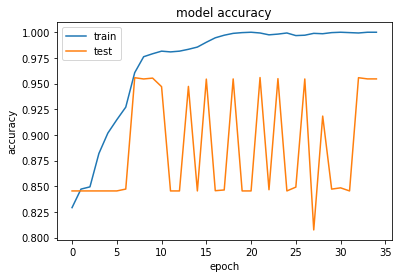

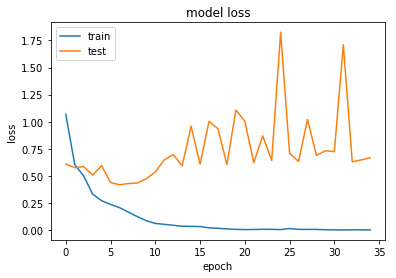

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

By looking at the test accuracy and loss curves, it seems that saving the best weights is the good approach. Class imbalance problem causes instability in the test loss/accuracy curves.

#### How does LSTM model compare to the XGBoost model? Why might these two models perform differently on this dataset?


XGBoost model contained pre-processing steps like creating the Bag of Word representation in which the words with more frequency distribution will influence the prediction. On the otherhand, LSTM model is a sequential model which learns about the entire context of the data with it's long-term memory component.With the short term memory component, it learns about the feature representations in the same way as learning about the representation of N-Grams.

I think LSTM should perform better if more hyper-parameter tuning is carried out and more data is used in training. So LSTM is better for text analysis as LSTM can learn about the entire context i.e. can be effective at sequential learning.

#### Deeper LSTM network with 2 LSTM layers. 

In [1]:
#though it does not work too well..

In [19]:
EMBEDDING_DIM = 300

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(LSTM(units=200, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(units=100, recurrent_dropout=0.3))
model.add(Dense(5, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())


Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 300)           540000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 200)           400800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,061,705
Trainable params: 1,061,705
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
print('Train...')
#y_train = pd.get_dummies(df['project_id'])
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
call_list = [checkpoint]

model.fit(X_train_pad, train_y_enc, batch_size=128, epochs=35, validation_data=(X_test_pad, test_y_enc), 
          verbose=2, class_weight=cl_weights, callbacks= call_list)

Train...
Instructions for updating:
Use tf.cast instead.
Train on 2768 samples, validate on 30885 samples
Epoch 1/35
 - 20s - loss: 0.8299 - acc: 0.8139 - val_loss: 0.5745 - val_acc: 0.8454

Epoch 00001: val_acc improved from -inf to 0.84539, saving model to weights-improvement-01-0.85.hdf5
Epoch 2/35
 - 17s - loss: 0.5138 - acc: 0.8508 - val_loss: 0.5617 - val_acc: 0.8454

Epoch 00002: val_acc did not improve from 0.84539
Epoch 3/35
 - 16s - loss: 0.2830 - acc: 0.8866 - val_loss: 0.5395 - val_acc: 0.8454

Epoch 00003: val_acc did not improve from 0.84539
Epoch 4/35
 - 17s - loss: 0.1957 - acc: 0.9491 - val_loss: 0.4410 - val_acc: 0.8454

Epoch 00004: val_acc did not improve from 0.84539
Epoch 5/35
 - 17s - loss: 0.1003 - acc: 0.9805 - val_loss: 0.5864 - val_acc: 0.8466

Epoch 00005: val_acc improved from 0.84539 to 0.84659, saving model to weights-improvement-05-0.85.hdf5
Epoch 6/35
 - 17s - loss: 0.0810 - acc: 0.9780 - val_loss: 0.4211 - val_acc: 0.9254

Epoch 00006: val_acc improved

In [21]:
test_pred = model.predict(X_test_pad)
confusion_matrix(np.argmax(test_y_enc, axis=1), np.argmax(test_pred, axis=1))

array([[26110,     0],
       [ 4727,    48]])

### Possibilities of the Future Improvements

1. There are variety of cutting-edge architects of the recurrent neural networks which will be interesting to try out. Keras has some more RNN architects that can be tried out https://keras.io/layers/recurrent/


2. We can try out the pre-trained word embeddings of word2vec or Glove https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html